### Import library

In [132]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn import tree
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from datetime import datetime as dt
# import seaborn as sns
from IPython.core.display import Image

In [158]:
def separate_list(arr, start, end,from_idx):
    if type(arr) is np.ndarray:
        arr_ext = arr[start:end]
        arr_res = np.r_[arr[from_idx:start], arr[end:-1]]
    elif type(arr) is list:
        arr_ext = arr[start:end]    
        arr_res = arr[from_idx:start] + arr[end:-1]
    return [arr_ext, arr_res]    

In [159]:
def create_traindata(given_data, test_idx, N, from_idx):
    data = [separate_list(d,test_idx[0], test_idx[1]) for d in given_data] 
    data_test = [d[0] for d in data] 
    data_train = [d[1] for d in data]

    true_data = data_test[0]

    train_label = data_train[0]
    train_data = [data_train[i] for i in range(1,N)]
    test_data = [data_test[i] for i in range(1,N)]    
    return train_data, train_label, test_data, true_data

In [134]:
def comp_plot(true_data, title='Title'):
    print(i+1)
    plt.subplot(2,2,i+1)
    plt.title(title, fontsize=30)
    plt.ylim(0,1400)
    plt.xlim(0,1400)
    plt.tick_params(labelsize=20)
    
    plt.hold(True);
    plt.plot(true_data,label="Observed irradiance",lw=1, color='gray')
    plt.plot(estimated_data, '--', label="Estimated irradiance", lw=1, color='black')
    plt.hold(False);
    plt.grid(True);
    plt.legend(fontsize=20,frameon=True,loc='upper right')
    plt.ylabel(r'Solar irradiance [$kWm^{-2}$]', fontsize=30)
    plt.xlabel('Local time (UTC+9)', fontsize=30)
    plt.savefig("RFestimate_and_observed.png", dpi=250)

In [135]:
def comp_plot2(dataset, days, title='Title'):
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    fs = 20;
    for i in range(0,len(test_idx)):        
        plt.subplot(2,2,i+1)
        plt.title(title, fontsize=fs)
        plt.ylim(0,1400)
        plt.xlim(0,1400)
        plt.tick_params(labelsize=fs)
        plt.hold(True);
        plt.plot(dataset[i]['true_data'],label="Ground obs. H",lw=2, color='lightgray')
        plt.plot(dataset[i]['estimated'], '--', label="Estimated H", lw=2, color='black')
        plt.grid(True)
        plt.title(title+'  2015/4/'+str(days[i]), fontsize=fs)
        plt.xticks([175*0,175*1,175*2,175*3,175*4,175*5,175*6,175*7 ], [0,3,6,9,12,15,18,21,0])
        plt.legend(fontsize=fs-2,frameon=True,loc='upper left')
        plt.ylabel(r'Solar irradiance [$kWm^{-2}$]', fontsize=fs)
        plt.xlabel('Local time (UTC+9)', fontsize=fs)
    plt.savefig(title+'_RF_patterns.png', dpi=250)

In [136]:
def comp_scatter(true_data, estimated_data, title='Title'):
    plt.figure(figsize=(10, 9))
    plt.grid()
    plt.title(title, fontsize=30)
    plt.ylim(0,1200)
    plt.xlim(0,1200)
    plt.tick_params(labelsize=20)
    t_est = np.array([1,1200]); t_true = np.array([1,1200]);
    plt.scatter(true_data, estimated_data, alpha=0.3, s=15, color='black')
    plt.plot(t_est,t_true, color='black');
    plt.ylabel(r'Ground measured solar irradiance [$kWm^{-2}$]', fontsize=30)
    plt.xlabel(r'Estimated solar irradiance [$kWm^{-2}$]', fontsize=30)
    plt.title(title, fontsize=30)
    plt.text(100,1100,r'r=%f '%(np.corrcoef((true_data, estimated_data))[0,1]) , fontsize=20)
    np.correlate(t_est,t_true)
    plt.savefig("RFaccuracy", dpi=250)


### Import data
- input data needed
    - obserbed timeseriese data 
    - albedo/tbb timeseriese data

In [137]:
stlfile = 'data/April/FREA/satellite/'
grmfile = 'data/April/FREA/ground_measure/'

In [138]:
files=[grmfile+'ts_FREA_H.txt',grmfile+'ts_FREA_extH.txt',stlfile+'ts_rhop_B01.txt',stlfile+'ts_rhop_B02.txt',stlfile+'ts_rhop_B03.txt',stlfile+'ts_rhop_B04.txt',stlfile+'ts_rhop_B05.txt', stlfile+'ts_rhop_B06.txt']

In [139]:
# Use all channel
files=[grmfile+'ts_FREA_H.txt',grmfile+'ts_FREA_extH.txt',stlfile+'ts_rhop_B01.txt',stlfile+'ts_rhop_B02.txt',stlfile+'ts_rhop_B03.txt',stlfile+'ts_rhop_B04.txt',stlfile+'ts_rhop_B05.txt', stlfile+'ts_rhop_B06.txt', stlfile+'ts_rhop_B07.txt', stlfile+'ts_rhop_B08.txt', stlfile+'ts_rhop_B09.txt', stlfile+'ts_rhop_B10.txt',stlfile+'ts_rhop_B11.txt',stlfile+'ts_rhop_B12.txt',stlfile+'ts_rhop_B13.txt',stlfile+'ts_rhop_B14.txt',stlfile+'ts_rhop_B15.txt',stlfile+'ts_rhop_B16.txt']

In [140]:
#files=[grmfile+'ts_FREA_H.txt',grmfile+'ts_FREA_extH.txt',stlfile+'ts_rhop_B01.txt',stlfile+'ts_rhop_B02.txt',stlfile+'ts_rhop_B03.txt',stlfile+'ts_rhop_B04.txt',stlfile+'ts_rhop_B05.txt', stlfile+'ts_rhop_B06.txt',grmfile+'ts_FREA_extH.txt']

In [141]:
# load files
data = [np.loadtxt(f,delimiter="\t", skiprows=1, dtype={'names':('Time','Value'),'formats':('S18','f8')}) for f in files]

In [142]:
DATA_NUM = len(data)
DATA_NUM

18

In [143]:
files

['data/April/FREA/ground_measure/ts_FREA_H.txt',
 'data/April/FREA/ground_measure/ts_FREA_extH.txt',
 'data/April/FREA/satellite/ts_rhop_B01.txt',
 'data/April/FREA/satellite/ts_rhop_B02.txt',
 'data/April/FREA/satellite/ts_rhop_B03.txt',
 'data/April/FREA/satellite/ts_rhop_B04.txt',
 'data/April/FREA/satellite/ts_rhop_B05.txt',
 'data/April/FREA/satellite/ts_rhop_B06.txt',
 'data/April/FREA/satellite/ts_rhop_B07.txt',
 'data/April/FREA/satellite/ts_rhop_B08.txt',
 'data/April/FREA/satellite/ts_rhop_B09.txt',
 'data/April/FREA/satellite/ts_rhop_B10.txt',
 'data/April/FREA/satellite/ts_rhop_B11.txt',
 'data/April/FREA/satellite/ts_rhop_B12.txt',
 'data/April/FREA/satellite/ts_rhop_B13.txt',
 'data/April/FREA/satellite/ts_rhop_B14.txt',
 'data/April/FREA/satellite/ts_rhop_B15.txt',
 'data/April/FREA/satellite/ts_rhop_B16.txt']

/Users/ojt_camp01/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


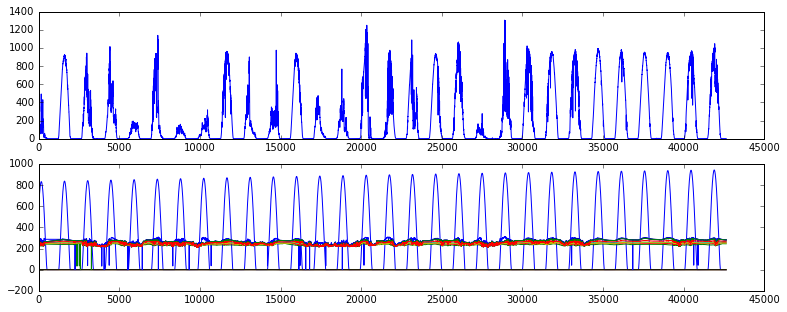

In [144]:
data2 = data
DATA_NUM = len(data)
# plot loaded data
labels = ['B01', 'B02','B05']
plt.figure(figsize=(13, 5))
plt.subplot(2,1,1)
plt.plot(data[0]['Value'],lw=1) # True data
plt.subplot(2,1,2)
[plt.plot(data[i]['Value'], lw=1, ) for i in range(1,DATA_NUM)] # Albedo data
plt.legend()
plt.savefig("FREAbands.png", dpi=250)

In [145]:
data2[0]['Time']

array([b"'01-Apr-2015 00:02", b"'01-Apr-2015 00:03", b"'01-Apr-2015 00:04",
       ..., b"'30-Apr-2015 14:57", b"'30-Apr-2015 14:58",
       b"'30-Apr-2015 14:59"], 
      dtype='|S18')

In [146]:
# add time column
data = [ d['Value'] for d in data ]

time_data = [dt.strptime(str(d)[3:20], '%d-%b-%Y %H:%M') for d in data2[0]['Time']]
#data.append(np.transpose([d.month for d in time_data]))
data.append(np.transpose([d.day for d in time_data]))
data.append(np.transpose([d.hour for d in time_data]))
data.append(np.transpose([d.minute for d in time_data]))

DATA_NUM = len(data)
#data = data[2500:40000]

In [147]:
[print(np.size(s)) for s in data]


42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650
42650


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Devide to train data and test data


In [148]:
idx_c = int((len(data[0])*0.7))
train_data = [d[2500:idx_c] for d in data]
train_label = train_data[0]
train_data = [train_data[i] for i in range(1,DATA_NUM)]

test_data  = [d[idx_c:] for d in data]
true_data = test_data[0]
B01_data = test_data[1] 
B02_data = test_data[2]
B05_data = test_data[3]

test_data = [test_data[i] for i in range(1,DATA_NUM)]

In [149]:
# DEBUG (checking the shape of data)
print(np.shape(np.transpose(train_data)))
print(np.shape(train_label))
print('test data size', np.shape(test_data))
print('true data size',np.shape(true_data))

(27354, 20)
(27354,)
test data size (20, 12796)
true data size (12796,)


### 訓練データの作成


In [150]:
train_data

[array([ -5.75432322e-10,  -5.72657511e-10,  -5.69870648e-10, ...,
         -4.71084858e-10,  -4.68314326e-10,  -4.65532166e-10]),
 array([  7.77142928e-12,   1.42857149e-04,   2.85714297e-04, ...,
          2.00000000e-04,   1.09731833e-11,   1.42857149e-04]),
 array([ 0.0005    ,  0.0005    ,  0.0005    , ...,  0.00073529,
         0.00079412,  0.00085294]),
 array([ 0.0005    ,  0.00035714,  0.00021429, ...,  0.001     ,
         0.001     ,  0.001     ]),
 array([ 0.00045   ,  0.00075   ,  0.00105   , ...,  0.00183333,
         0.0025    ,  0.002     ]),
 array([ 0.00045   ,  0.00075   ,  0.00105   , ...,  0.00183333,
         0.0025    ,  0.002     ]),
 array([ 0.    ,  0.    ,  0.    , ...,  0.001 ,  0.001 ,  0.0008]),
 array([ 269.56525   ,  269.53497571,  269.50470143, ...,  275.39776333,
         275.50768999,  275.41315571]),
 array([ 246.81499   ,  246.81499   ,  246.81499   , ...,  239.49608   ,
         239.4005    ,  239.31800571]),
 array([ 256.25104 ,  256.2044  ,  256.

#### 各パターンの日時インデックスをセット


In [152]:
test_idx=[]
test_idx.append([36894,38332])
test_idx.append([5222,6660])
test_idx.append([41214,42651])
test_idx.append([19622,21060])
test_idx

[[36894, 38332], [5222, 6660], [41214, 42651], [19622, 21060]]

#### パターン A
##### テストデータと訓練データの生成


##### テストデータに対する真のデータの生成


##### 訓練データのラベルとデータへの分離


In [153]:
N = DATA_NUM
dataset = [];
for i in range(0,len(test_idx)):
    ti = test_idx[i]
    [train_data, train_label, test_data, true_data] = create_traindata(data, ti, N)
    dict = {'train_data': train_data, 'train_label': train_label, 'test_data':test_data, 'true_data': true_data}
    dataset.append(dict)

### Estimation irradiance by Random Forest


In [154]:
estimated = [];
for i in range(0,1): 
    estimator = RandomForestRegressor()
    model = RandomForestRegressor(n_estimators=10, n_jobs=-1)
    model.fit(np.transpose(train_data), np.array(train_label, dtype=np.float64))
    estimated.append(model.predict(np.transpose(test_data)))

#### 共通


In [155]:
N_est = 30

In [156]:
for i in range(0,len(test_idx)):
    estimated = [];
    estimator = RandomForestRegressor()
    model = RandomForestRegressor(n_estimators=N_est,n_jobs=-1)
    model.fit(np.transpose(dataset[i]['train_data']), np.array(dataset[i]['train_label'], dtype=np.float64))
    dataset[i].update({'estimated':model.predict(np.transpose(dataset[i]['test_data']))})

## Result

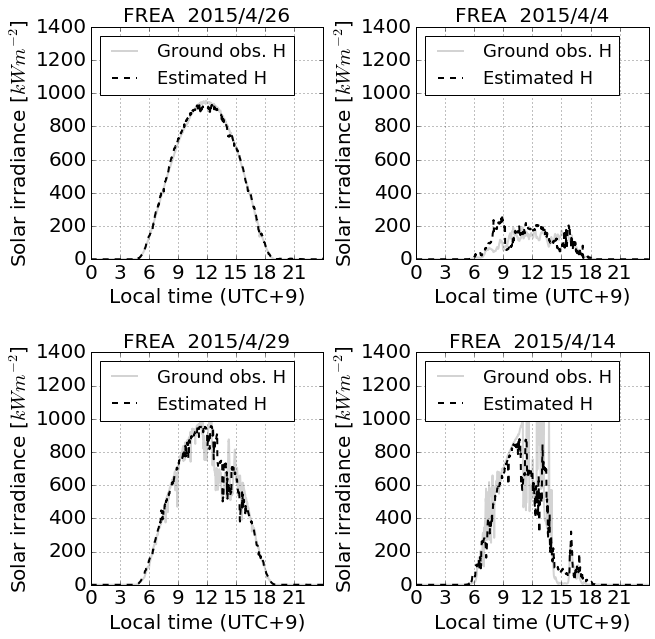

In [160]:
days  = [26, 4, 29, 14];
comp_plot2(dataset, days, title='FREA')